### Imports and Definitions

In [36]:
from functions import *
from SQL_functions import *
from stats_forumulas import *
import config
import matplotlib.pyplot as plt
import mysql.connector
from mysql.connector import errorcode
import math
import pandas as pd
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Do abortion laws influence how many women end up working in tech?

We have two measures of "women working in tech":
 - Prevalence of women in tech (percentage of tech industry workers who are women)
 - Percentage difference of prevalence of women in tech versus prevalence of women in workforce overall
 
 Let's try each of these and see the result.

#### Influence of Abortion: Using Prevalence of Women in Tech

In [51]:
query1 = get_attributes_query(('value', 'laws'), 'abortion_info',
                              ('percent_women_in_tech', 'percent_women_in_tech'))

In [52]:
df1 = get_data(query1)

In [54]:
anova_table_and_summary(df1, 'percent_women_in_tech', 'C(laws)')

                              OLS Regression Results                             
Dep. Variable:     percent_women_in_tech   R-squared:                       0.065
Model:                               OLS   Adj. R-squared:                 -0.038
Method:                    Least Squares   F-statistic:                    0.6297
Date:                   Thu, 03 Oct 2019   Prob (F-statistic):              0.644
Time:                           14:11:39   Log-Likelihood:                -123.27
No. Observations:                     41   AIC:                             256.5
Df Residuals:                         36   BIC:                             265.1
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       15

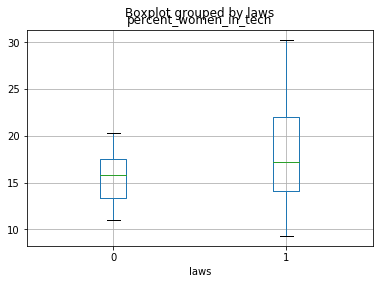

In [54]:
df1.boxplot('percent_women_in_tech', by='laws')

#### Influence of Abortion: % Difference in Prevalence of Women in Tech versus Overall Workforce

In [39]:
query2 = get_attributes_query(('value', 'laws'), 'abortion_info',
                              ('percent_difference_of_women_in_workforce_and_women_in_tech', 'percent_difference_of_women_in_workforce_and_women_in_tech'))

In [40]:
df2 = get_data(query2)

In [55]:
anova_table_and_summary(df2, 'percent_difference_of_women_in_workforce_and_women_in_tech', 'C(laws)')

                                                OLS Regression Results                                                
Dep. Variable:     percent_difference_of_women_in_workforce_and_women_in_tech   R-squared:                       0.018
Model:                                                                    OLS   Adj. R-squared:                 -0.008
Method:                                                         Least Squares   F-statistic:                    0.6999
Date:                                                        Thu, 03 Oct 2019   Prob (F-statistic):              0.408
Time:                                                                14:11:52   Log-Likelihood:                -119.93
No. Observations:                                                          41   AIC:                             243.9
Df Residuals:                                                              39   BIC:                             247.3
Df Model:                                       

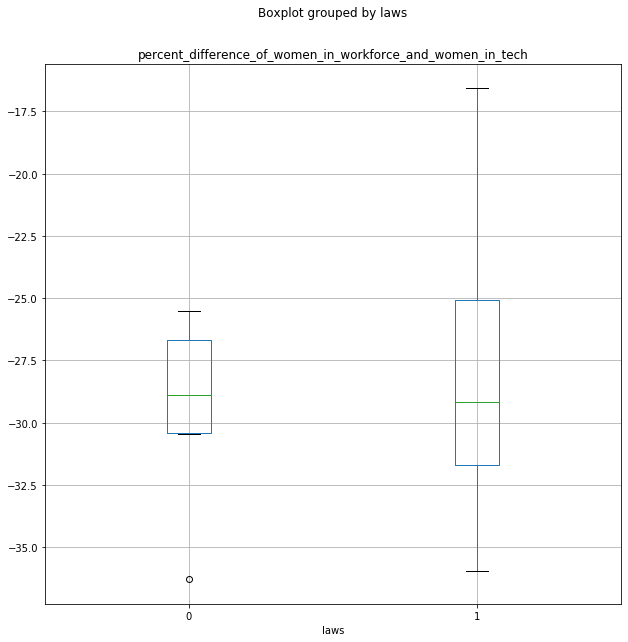

In [59]:
df2.boxplot('percent_difference_of_women_in_workforce_and_women_in_tech', by='laws',figsize = (10,10));

## Let's redo those same tests, but this time with fewer categories (just to see what happens)

In [45]:
df1_cat = df1
df1_cat['laws'] = df1_cat['laws'].apply(lambda x: 1 if x > 5 else 0)

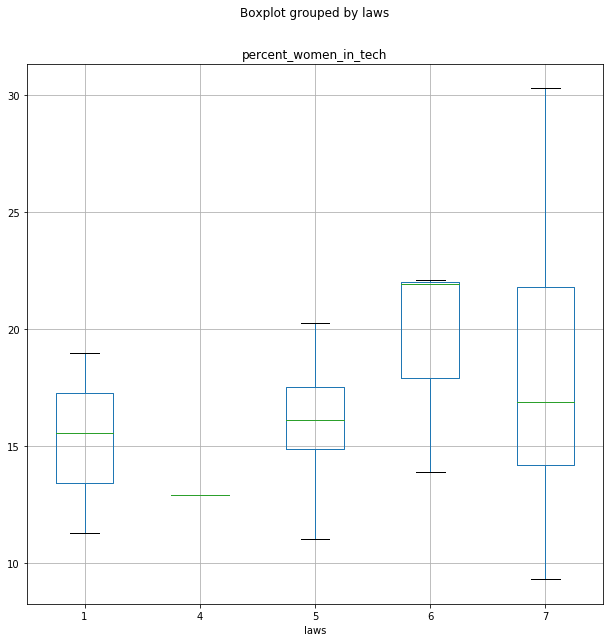

In [58]:
import matplotlib.pyplot as plt
df1.boxplot('percent_women_in_tech', by='laws', figsize = (10,10));

In [46]:
df2_cat = df2
df2_cat['laws'] = df2['laws'].apply(lambda x: 1 if x > 5 else 0)

In [62]:
anova_table_and_summary(df1, 'percent_women_in_tech', 'laws');

                              OLS Regression Results                             
Dep. Variable:     percent_women_in_tech   R-squared:                       0.065
Model:                               OLS   Adj. R-squared:                 -0.038
Method:                    Least Squares   F-statistic:                    0.6297
Date:                   Thu, 03 Oct 2019   Prob (F-statistic):              0.644
Time:                           14:15:07   Log-Likelihood:                -123.27
No. Observations:                     41   AIC:                             256.5
Df Residuals:                         36   BIC:                             265.1
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       15

In [60]:
anova_table_and_summary(df2_cat, 'percent_difference_of_women_in_workforce_and_women_in_tech', 'laws')

                                                OLS Regression Results                                                
Dep. Variable:     percent_difference_of_women_in_workforce_and_women_in_tech   R-squared:                       0.018
Model:                                                                    OLS   Adj. R-squared:                 -0.008
Method:                                                         Least Squares   F-statistic:                    0.6999
Date:                                                        Thu, 03 Oct 2019   Prob (F-statistic):              0.408
Time:                                                                14:13:50   Log-Likelihood:                -119.93
No. Observations:                                                          41   AIC:                             243.9
Df Residuals:                                                              39   BIC:                             247.3
Df Model:                                       

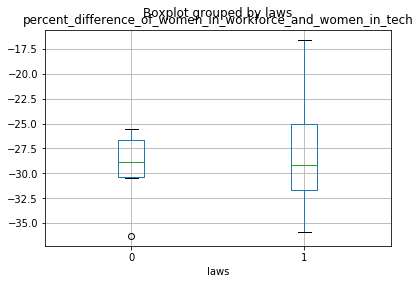

In [53]:
df2.boxplot('percent_difference_of_women_in_workforce_and_women_in_tech', by='laws')

### Attempt to replicate a study when we restrict to only EU + OECD countries:
### Does the gender inequality index negatively affect the percentage of STEM graduates who are female?

In [97]:
q = get_attributes_query(('gender_inequality_index', 'gender_inequality_index'), 
                     'women_in_tech', ('female_stem_graduates_percentage','female_stem_graduates_percentage'))

In [98]:
gend_df = get_data(q)

In [111]:
gend_df.dtypes

country                              object
gender_inequality_index               int64
female_stem_graduates_percentage    float64
dtype: object

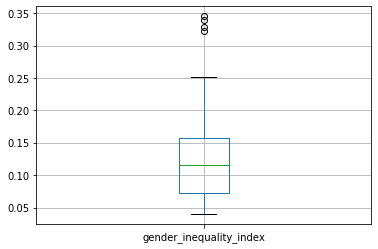

In [100]:
gend_df.boxplot('gender_inequality_index');

In [101]:
med = gend_df['gender_inequality_index'].median()

In [102]:
gend_df['gender_inequality_index'] = \
    gend_df['gender_inequality_index'].apply(lambda x: 1 if x> med else 0)

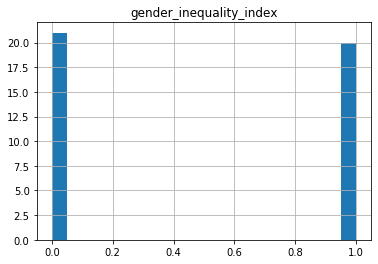

In [103]:
gend_df.hist('gender_inequality_index', bins = 20);

In [119]:
gend_df[gend_df['gender_inequality_index'] == 0]['female_stem_graduates_percentage']

1     20.63
2     18.03
4     24.81
7     28.57
9     28.57
11    20.00
12    25.37
13    21.26
16    27.54
18    24.81
19    33.33
20    15.25
21    21.26
24    28.57
27    18.70
29    19.35
31    30.56
34    21.88
35    25.93
36    22.48
37    21.88
Name: female_stem_graduates_percentage, dtype: float64

In [120]:
stats.ttest_ind(gend_df[gend_df['gender_inequality_index'] == 0]['female_stem_graduates_percentage'],
                gend_df[gend_df['gender_inequality_index'] == 1]['female_stem_graduates_percentage'])

Ttest_indResult(statistic=-0.6783800154046294, pvalue=0.5015364299038596)

In [122]:
stats.pearsonr(gend_df['gender_inequality_index'], gend_df['female_stem_graduates_percentage'])

(0.10799245333391644, 0.5015364299038582)

In [123]:
gendf = get_data(q)

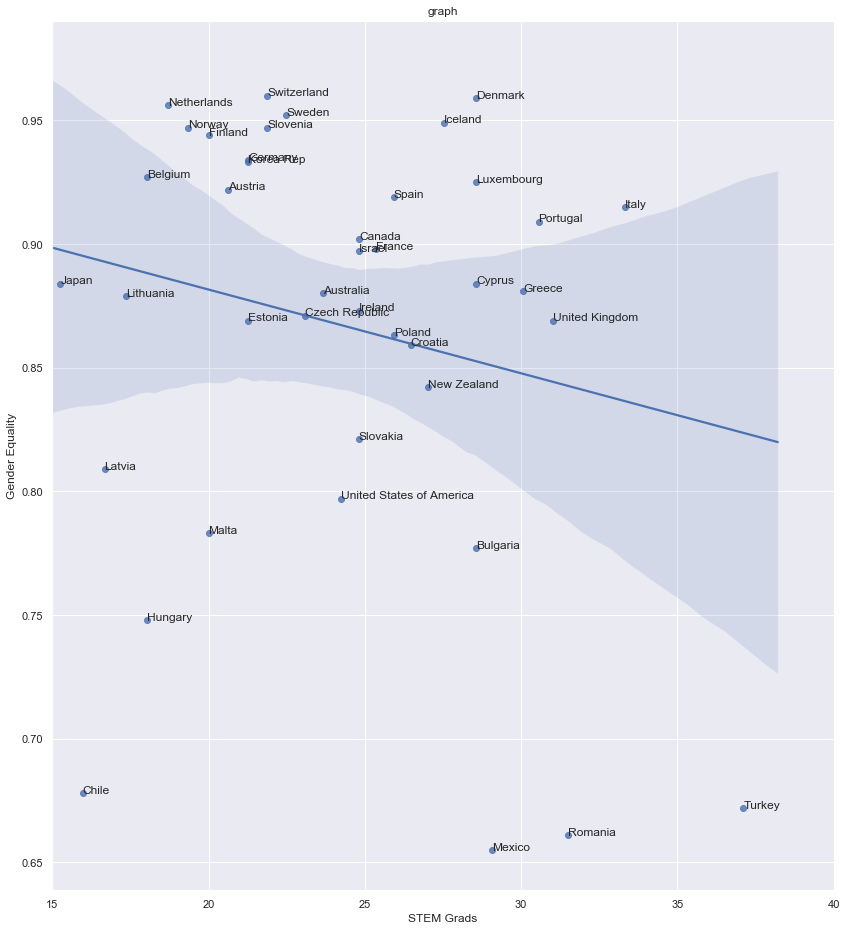

In [164]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize': (14,16)})
txt = list(gendf['country'])
x = list(gendf['female_stem_graduates_percentage'])
y = list(1-(gendf["gender_inequality_index"]))
ax = sns.regplot(x,y)
ax.set(title = 'graph', xlabel='STEM Grads', ylabel='Gender Equality', xlim = (15,40));
for i in range(len(txt)):
    ax.annotate(txt[i], (x[i], y[i]))

### Female Higher Ed Enrollment versus Proportion of Women Workers in Tech

In [87]:
higher_ed_query = '''
        SELECT
            w. country
                AS country,
            100*w.female_tech_workforce_thousands / (w.female_workforce_millions * 1000)
                AS perc_women_workers_in_tech,
            100 * max(t.value) / p.value
                AS women_enrolled_in_ter_ed_as_perc_of_total_pop
        FROM
            gender.women_in_tech AS w
            JOIN
            gender.ter_ed_enrollment AS t
            ON w.country = t.country
            JOIN gender.population_data_full as p
            ON w.country = p.country
        WHERE
            t.subgroup = "Female"
        GROUP BY
            t.country;'''


df_edu = get_data(higher_ed_query)

In [88]:
df_edu

,country,perc_women_workers_in_tech,women_enrolled_in_ter_ed_as_perc_of_total_pop
0,Australia,2.298129,2.2130
1,Austria,1.461905,1.5511
2,Belgium,1.192140,1.8558
3,Bulgaria,1.580645,2.2866
4,Canada,2.434783,2.0209
5,Chile,1.400562,1.7061
6,Croatia,0.851852,1.5833
7,Cyprus,0.842105,0.8780
8,Czech Republic,0.852321,1.6654
9,Denmark,1.671329,2.3006
